# Libraries used

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
!pip install neattext
import neattext.functions as nfx
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
import pickle
from sklearn.preprocessing import LabelEncoder
import keras
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Loading the Dataset

In [2]:
data = pd.read_csv('D:\ML projects\Sucide text analysis\Suicide_Detection.csv')

# Spiltting the Data

In [3]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

# Data Visualization

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [5]:
data.head(10)

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
5,11,Honetly idkI dont know what im even doing here...,suicide
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide
7,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide
8,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide
9,18,My life is over at 20 years oldHello all. I am...,suicide


In [6]:
data.tail(10)

,Unnamed: 0,text,class
232064,348096,How ba-a-ad can i be? I’m just doin’ what come...,non-suicide
232065,348097,I know no one here cares but anyways I was fig...,non-suicide
232066,348098,My mom tried to kill herself today. I feel los...,suicide
232067,348100,I’m a fucking scummy person and I can’t change...,suicide
232068,348101,I did something today I went sledding with my ...,non-suicide
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide
232073,348110,I still haven't beaten the first boss in Hollo...,non-suicide


In [7]:
data['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

In [8]:
data['class'].value_counts().index.values


array(['suicide', 'non-suicide'], dtype=object)

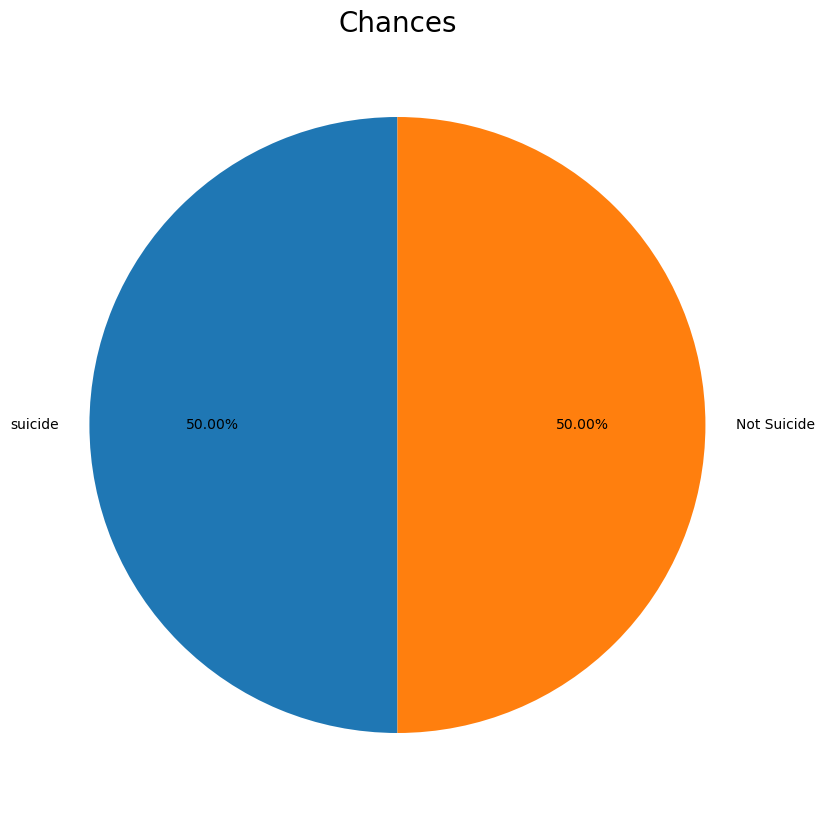

In [9]:
plt.figure(figsize=(12,10))
plt.pie(train_data['class'].value_counts(),startangle=90, autopct='%0.2f%%',labels=['suicide','Not Suicide'])
plt.title('Chances',fontdict={'size':20})
plt.show()

# Data Cleaning

In [10]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [11]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|█████████████████████████████████████████████████████████████████████████| 46415/46415 [00:02<00:00, 18741.84it/s]


C:\Users\rajak\AppData\Local\Temp\ipykernel_21468\483792958.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(train_text_length)


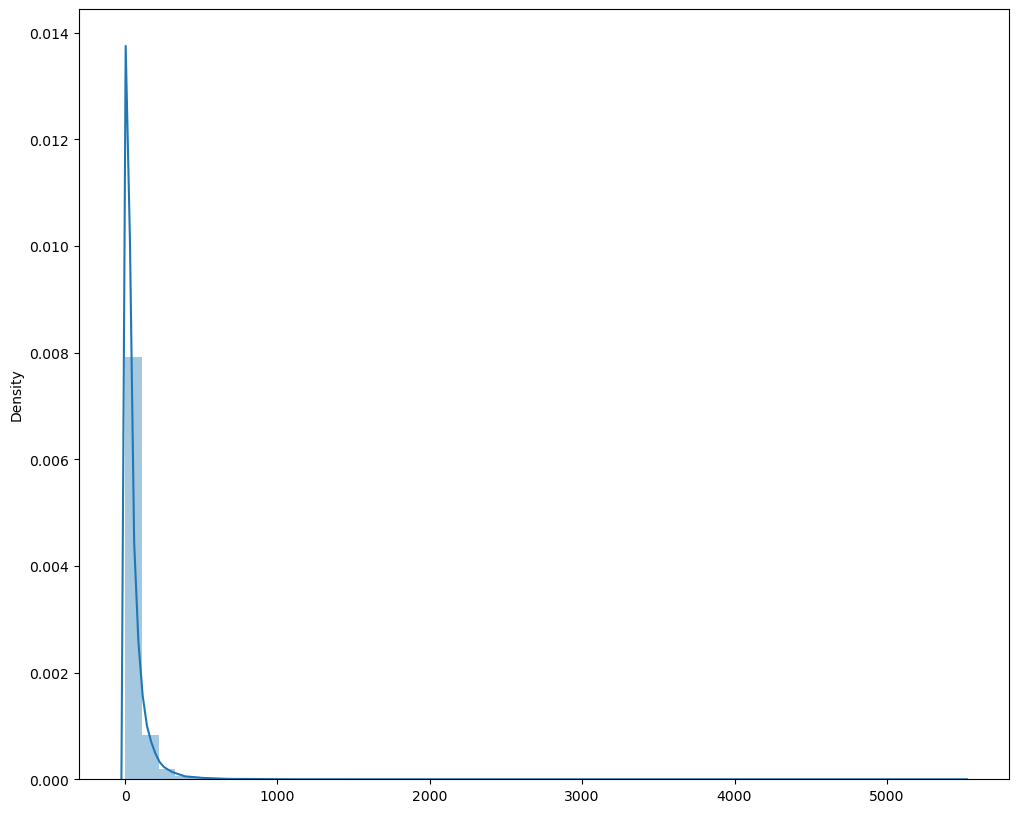

In [12]:
plt.figure(figsize=(12,10))
sn.distplot(train_text_length)
plt.show()


In [13]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [14]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

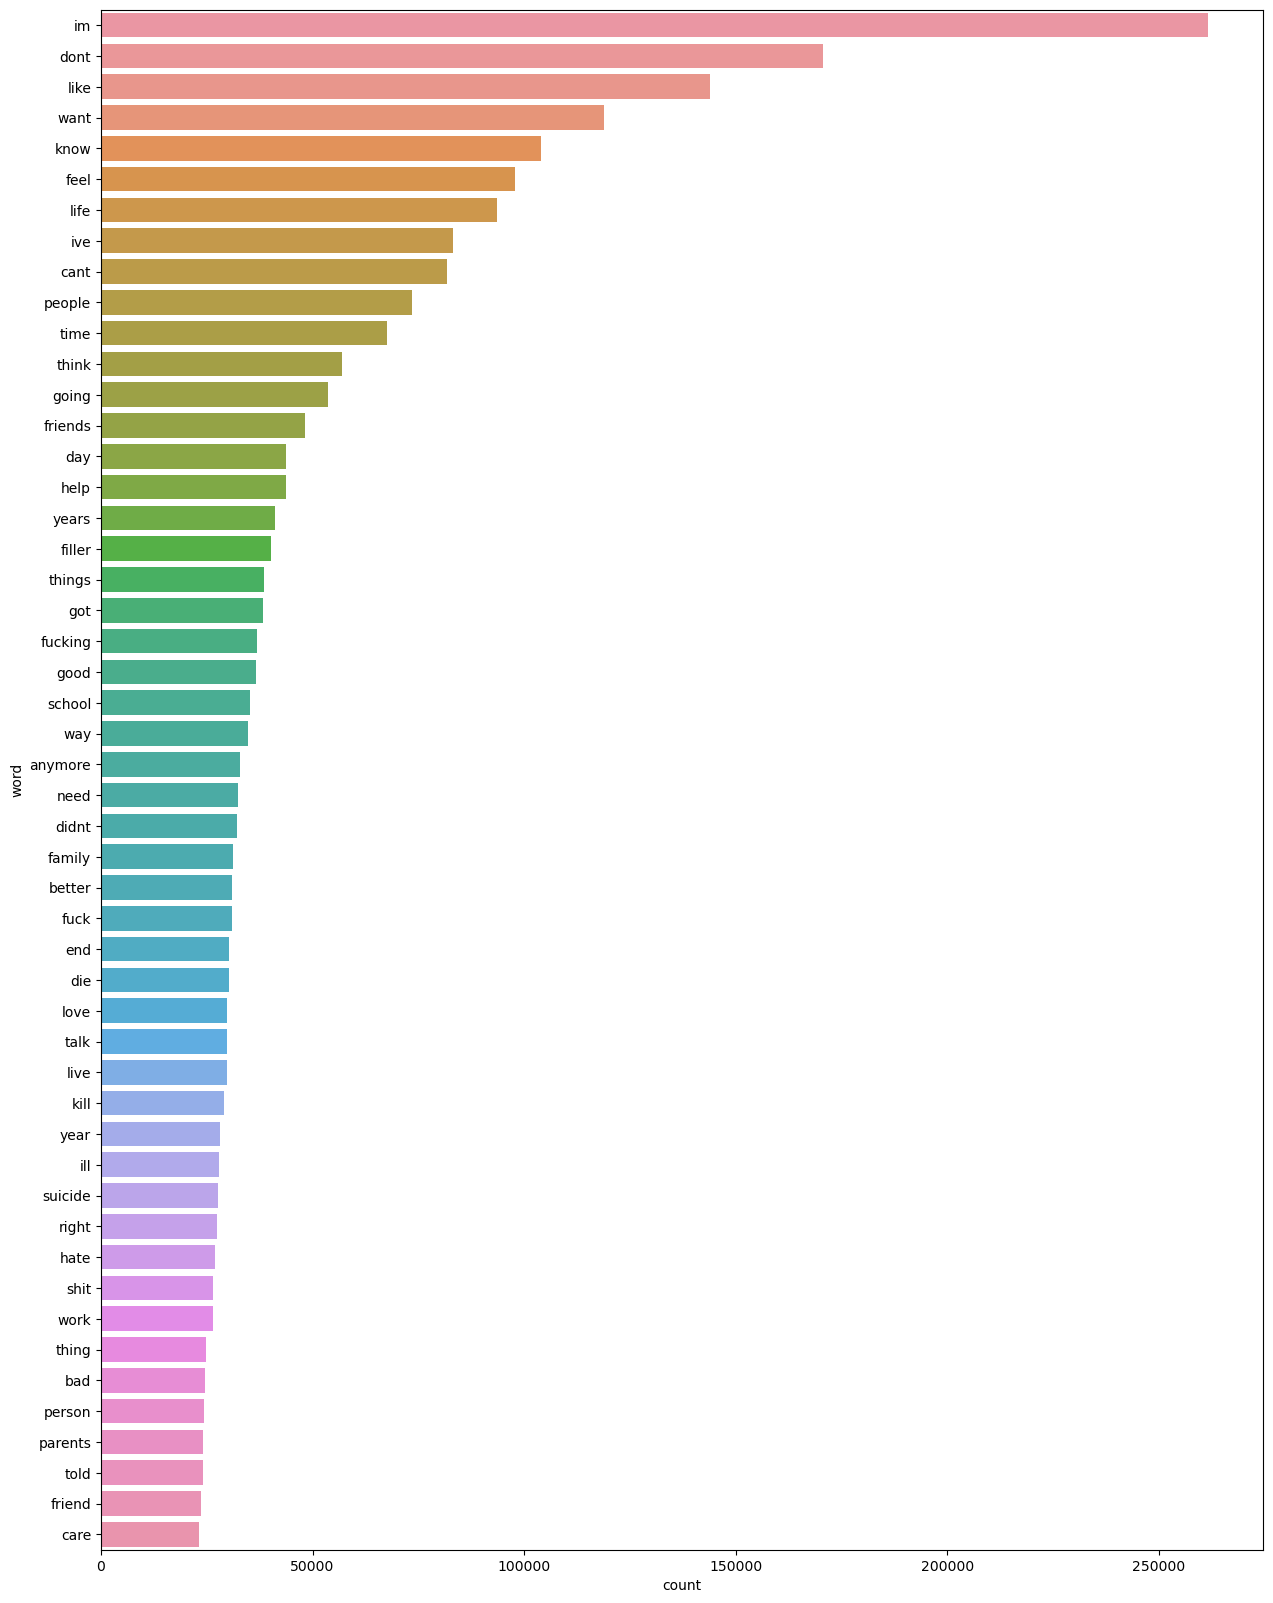

In [15]:
plt.figure(figsize=(15,20))
sn.barplot(x='count',y='word',data=word_freq.iloc[:50])
plt.show()

# Preprocessing Text Data

In [16]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [17]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

# Glove Embedding

In [18]:
# glove_embedding={}
with open('D:\ML projects\Sucide text analysis\glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [19]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [20]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

# Model Building

In [21]:

import tensorflow.keras.optimizers as Optimizer

# Define the model
model = Sequential()
model.add(Input(shape=(50,)))  # Input layer with input shape of (40,)
model.add(Embedding(input_dim=v+1, output_dim=300, weights=[embedding_matrix], trainable=False))  # Embedding layer with vocabulary size, embedding dimension, and pre-trained embedding weights
model.add(LSTM(20, return_sequences=True))  # LSTM layer with 20 units and return sequences set to True
model.add(GlobalMaxPooling1D())  # Global Max Pooling layer
model.add(Dense(256, activation='relu'))  # Dense layer with 256 units and ReLU activation
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
optimizer = Optimizer.SGD(learning_rate=0.1, momentum=0.09)  # SGD optimizer with learning rate and momentum
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

          

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           81560700  
                                                                 
 lstm (LSTM)                 (None, 50, 20)            25680     
                                                                 
 global_max_pooling1d (Globa  (None, 20)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 81,592,013
Trainable params: 31,313
Non-trainable params: 81,560,700
_______________________________________

In [22]:
r = model.fit(train_text_pad, train_output, validation_data=(test_text_pad, test_output),
             epochs=20, batch_size=1000, callbacks=[early_stop, reducelr])


Epoch 1/20
186/186 [==============================] - 42s 210ms/step - loss: 0.5090 - accuracy: 0.7616 - val_loss: 0.3397 - val_accuracy: 0.8625 - lr: 0.1000
Epoch 2/20
186/186 [==============================] - 36s 194ms/step - loss: 0.3179 - accuracy: 0.8691 - val_loss: 0.2759 - val_accuracy: 0.8904 - lr: 0.1000
Epoch 3/20
186/186 [==============================] - 36s 195ms/step - loss: 0.2776 - accuracy: 0.8872 - val_loss: 0.2541 - val_accuracy: 0.8993 - lr: 0.1000
Epoch 4/20
186/186 [==============================] - 36s 191ms/step - loss: 0.2589 - accuracy: 0.8958 - val_loss: 0.2491 - val_accuracy: 0.9013 - lr: 0.1000
Epoch 5/20
186/186 [==============================] - 36s 194ms/step - loss: 0.2506 - accuracy: 0.9000 - val_loss: 0.2366 - val_accuracy: 0.9070 - lr: 0.1000
Epoch 6/20
186/186 [==============================] - 36s 192ms/step - loss: 0.2416 - accuracy: 0.9037 - val_loss: 0.2388 - val_accuracy: 0.9065 - lr: 0.1000
Epoch 7/20
186/186 [==============================] 

In [23]:
from keras.models import save_model
model.save('trained_model.h5')

# Model Evaluation


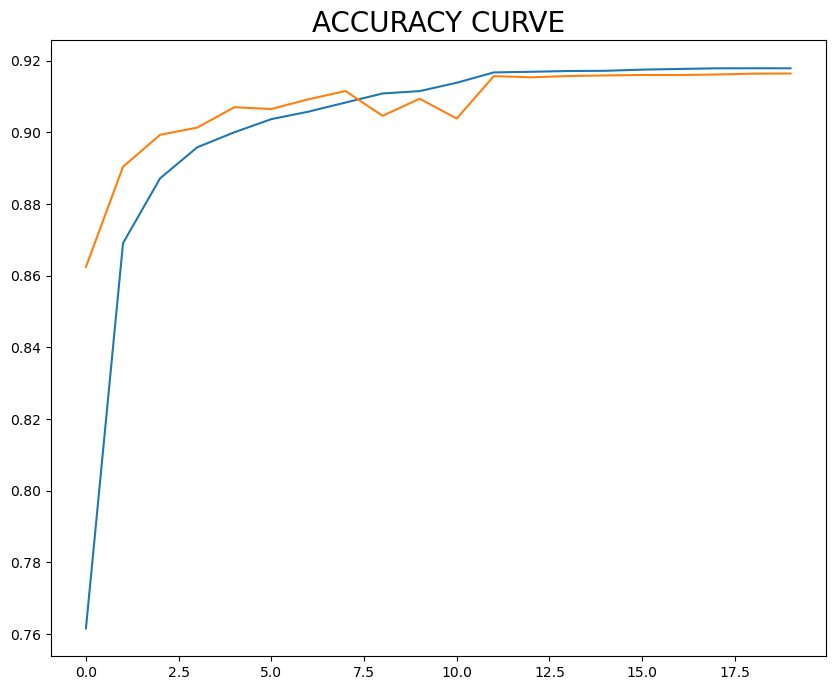

In [24]:
plt.figure(figsize=(10,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()


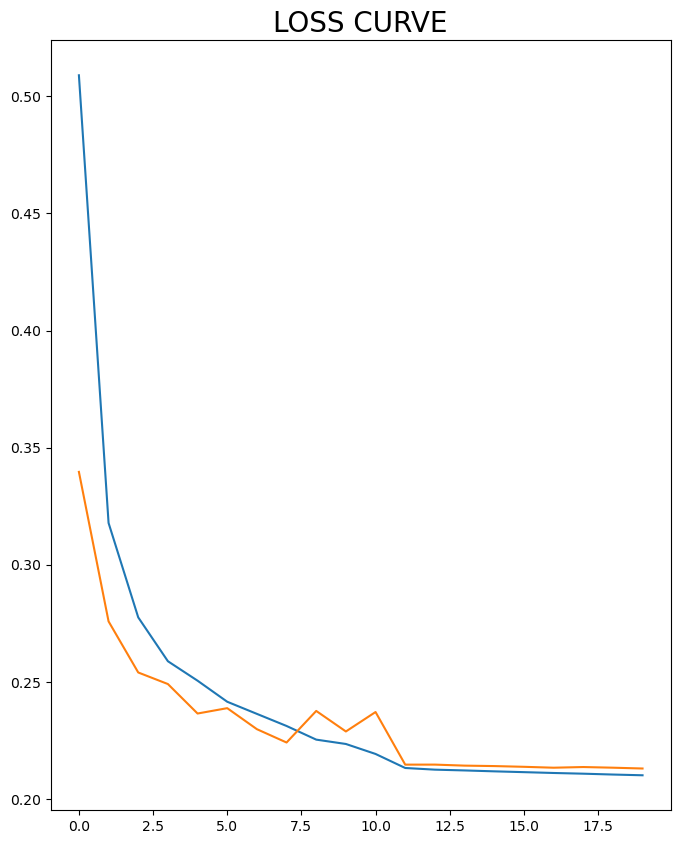

In [25]:
plt.figure(figsize=(8,10))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [27]:
# Reshape test_text_pad to have three dimensions
test_text_pad = np.reshape(test_text_pad, (test_text_pad.shape[0], test_text_pad.shape[1], 1))

# Get the predicted labels
y_test_arg = np.argmax(test_text_pad, axis=1)
categorical_pred = np.argmax(model.predict(test_text_pad), axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test_arg, categorical_pred)
print('Data Accuracy: {:.2f}%'.format(accuracy * 100))


1451/1451 [==============================] - 12s 8ms/step
Data Accuracy: 0.95%


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)